In [2]:
import numpy as np
from sklearn.preprocessing import normalize
import cv2
import matplotlib.pyplot as plt

In [3]:
# im2, im6 for all images except for tsukuba, which is im3,im4
imgL = cv2.imread('testdata/teddy/im2.png')  # downscale images for faster processing
imgR = cv2.imread('testdata/teddy/im6.png')

In [4]:
# venus 32,8  teddy 64,4  cones 64,4, tsukuba 16,16
MAX_DISPARITY = 64
SCALE_FACTOR = 4

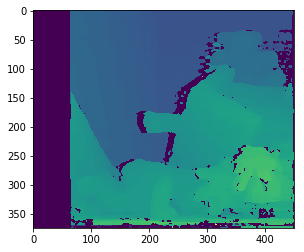

In [11]:
window_size = 7                    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely

left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=MAX_DISPARITY,             # max_disp has to be dividable by 16 f. E. HH 192, 256
    blockSize=5,
    P1=7 * 3 * window_size ** 2,   # disparity smoothnesss terms
    P2=30 * 3 * window_size ** 2,  # disparity smoothnesss terms, 27*3 yields 18.03
    disp12MaxDiff=1, # Max allowed difference (in integer pixel units) in the left-right disparity check
    uniquenessRatio=4,
    speckleWindowSize=0,
    speckleRange=0,
    preFilterCap=40,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

# computing the right-view disparity map that is required in case of filtering with confidence.
right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)

# are these automatically scaled up by 16?
displ = left_matcher.compute(imgL, imgR) / 16 # * SCALE_FACTOR  # .astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL) / 16 # * SCALE_FACTOR  # .astype(np.float32)/16

plt.imshow(displ)

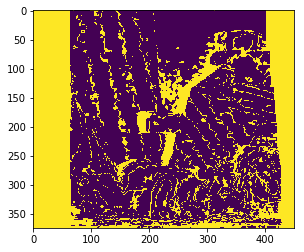

In [12]:
occluded = np.zeros(displ.shape)
for i in range(len(displ)):
    for j in range(len(displ[i])):
        left_disp = int(displ[i, j])
        if left_disp < 0 or (j-left_disp) < 0:
            occluded[i,j] = 1
        else:
            right_disp = -int(dispr[i, j-left_disp])
            if abs(right_disp - left_disp) > 0:
                occluded[i,j] = 1
                
plt.imshow(occluded)

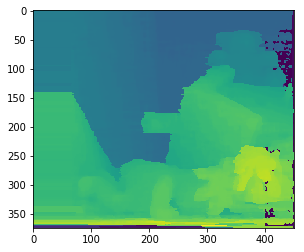

In [13]:
right_offset = 50
displ_fix_occlusion = displ.copy()

for i in range(len(displ_fix_occlusion)):
    for j in range(len(displ_fix_occlusion[i]) - right_offset):
        if occluded[i,j] == 1:
            
            min_dist_defined = False
            nearest_disp = 0
            
            for x in range(j-1,-1,-1): # going left
                if occluded[i,x] == 0:
                    min_dist = j-x # min_dist not defined yet
                    min_dist_defined = True
                    nearest_disp = displ_fix_occlusion[i, x]
                    break
                    
            for x in range(j+1, len(displ_fix_occlusion[i])): # going right
                if occluded[i,x] == 0:
                    if not min_dist_defined or (x-j) < min_dist:
                        nearest_disp = displ_fix_occlusion[i, x]
                        break
            displ_fix_occlusion[i,j] = nearest_disp

plt.imshow(displ_fix_occlusion)

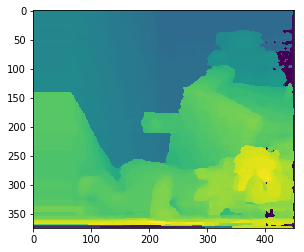

In [14]:
median = cv2.medianBlur(np.float32(displ_fix_occlusion),5)
plt.imshow(median)

In [15]:
# displ = wls_filter.filter(displ, imgL, None, dispr, right_view=imgR)
# plt.imshow(displ)

In [16]:
cv2.imwrite('teddy.png', median*SCALE_FACTOR)

True

#### code below not used for final submission

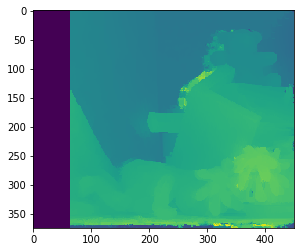

In [359]:
filteredImg = wls_filter.filter(displ, imgL, None, dispr, right_view=imgR)
plt.imshow(filteredImg)

In [215]:
non_negative_idx = 0
for i in range(len(median[0])):
    if median[0][i] > 0:
        non_negative_idx = i
        break

In [216]:
for i in range(non_negative_idx):
    median[:,i] = median[:,non_negative_idx]

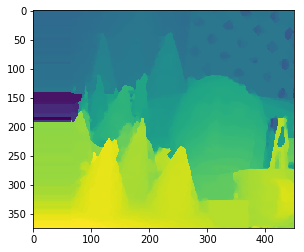

In [217]:
plt.imshow(median)

In [171]:
my_filter = cv2.ximgproc.createGuidedFilter(imgL, radius=5, eps=)

In [172]:
test = my_filter.filter(displ)

error: OpenCV(3.4.2) /Users/travis/build/skvark/opencv-python/opencv_contrib/modules/ximgproc/src/guided_filter.cpp:714: error: (-215:Assertion failed) !src.empty() && (src.depth() == 5 || src.depth() == 0) in function 'filter'


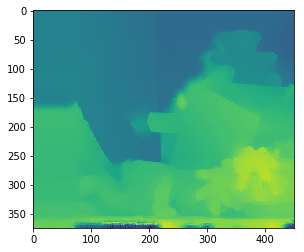

In [154]:
plt.imshow(test)

In [148]:
cv2.imwrite('teddy.png', test)

True